In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

numpy version :  2.0.2
pandas version :  2.2.2
seaborn version :  0.13.2


## Load Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd

# Load the Excel file to check sheet names
file_path = "/content/drive/MyDrive/Final Project/E Commerce Dataset.xlsx"
excel_file = pd.ExcelFile(file_path)

# Display the sheet names
sheet_names = excel_file.sheet_names
sheet_names

['Data Dict', 'E Comm']

In [7]:
# Baca beberapa baris pertama dari masing-masing sheet
data_dict_df = excel_file.parse('Data Dict').head()
e_comm_df = excel_file.parse('E Comm').head()

data_dict_df, e_comm_df

(   Unnamed: 0 Unnamed: 1            Unnamed: 2  \
 0         NaN       Data              Variable   
 1         NaN     E Comm            CustomerID   
 2         NaN     E Comm                 Churn   
 3         NaN     E Comm                Tenure   
 4         NaN     E Comm  PreferredLoginDevice   
 
                            Unnamed: 3  
 0                         Discerption  
 1                  Unique customer ID  
 2                          Churn Flag  
 3  Tenure of customer in organization  
 4  Preferred login device of customer  ,
    CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
 0       50001      1     4.0         Mobile Phone         3              6.0   
 1       50002      1     NaN                Phone         1              8.0   
 2       50003      1     NaN                Phone         1             30.0   
 3       50004      1     0.0                Phone         3             15.0   
 4       50005      1     0.0           

In [8]:
e_comm_df.head(5)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


## Preprocessing data

In [9]:
e_comm_df.duplicated().sum()

np.int64(0)

In [10]:
# Load full dataset for preprocessing
e_comm_df = excel_file.parse('E Comm')

# Ringkasan awal: tipe data dan missing values
data_info = e_comm_df.info()
missing_values = e_comm_df.isnull().sum().sort_values(ascending=False)

missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

,0
DaySinceLastOrder,307
OrderAmountHikeFromlastYear,265
Tenure,264
OrderCount,258
CouponUsed,256
HourSpendOnApp,255
WarehouseToHome,251
CustomerID,0
PreferredLoginDevice,0
Churn,0


In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Salin dataframe untuk preprocessing
df = e_comm_df.copy()

# Drop kolom ID karena tidak informatif untuk prediksi
df.drop(columns=["CustomerID"], inplace=True, errors="ignore")
df = df.dropna(subset=['Churn'])  # pastikan target tidak kosong

Berdasarkan analisis awal, terdapat beberapa kolom dengan missing values (nilai kosong), di antaranya:
- DaySinceLastOrder = 307
- OrderAmountHikeFromlastYear = 265
- Tenure = 264
- OrderCount = 258
- CouponUsed = 256
- HourSpendOnApp = 255
- WarehouseToHom = 251

## Preparasi Data & Feature Engineering

### Imputasi Data Kosong

In [12]:
from sklearn.impute import SimpleImputer

# Identifikasi kolom numerik, kecuali target
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Churn']).columns.tolist()

# Numerik: median
num_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# Kategorikal: modus
# Identifikasi kolom kategorikal
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

- Kolom numerik seperti Tenure, OrderAmountHikeFromlastYear, CouponUsed, dll. diisi menggunakan nilai median.

Note : Median lebih tahan terhadap outlier dibandingkan mean.

- Kolom kategorikal seperti Gender, PreferredPaymentMode, dan MaritalStatus diisi dengan nilai yang paling sering muncul (modus).

- Jumlah nilai kosong yang ditangani:

Total 7 kolom numerik dan semua berhasil diimputasi.

Tidak ditemukan kolom kategorikal yang memiliki missing value, sehingga tidak ada imputasi tambahan di bagian ini.

### One-Hot Encoding

In [13]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cat = encoder.fit_transform(df[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_cols))

# Gabung hasil encoding dengan kolom numerik dan target
df_model = pd.concat([df.drop(columns=categorical_cols), encoded_cat_df], axis=1)

# Tampilkan hasil akhir setelah preprocessing
df_model.head()

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1,4.0,3.0,6.0,3.0,3.0,2.0,9.0,1.0,11.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,9.0,1.0,8.0,3.0,4.0,3.0,7.0,1.0,15.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1,9.0,1.0,30.0,2.0,4.0,3.0,6.0,1.0,14.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,0.0,3.0,15.0,2.0,4.0,5.0,8.0,0.0,23.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,0.0,1.0,12.0,3.0,3.0,5.0,3.0,0.0,11.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


- Menggunakan OneHotEncoder dengan opsi drop='first':

Note : Menghindari dummy variable trap (kolinearitas antara fitur).

Hasil encoding:

- Gender → menjadi satu kolom baru: Gender_Male (karena Female di-drop sebagai baseline).

- PreferredLoginDevice → menjadi kolom seperti PreferredLoginDevice_Phone, PreferredLoginDevice_Computer, dll.

## EDA (Exploratory Data Analysis)

### Distribusi Churn (Target Variable)

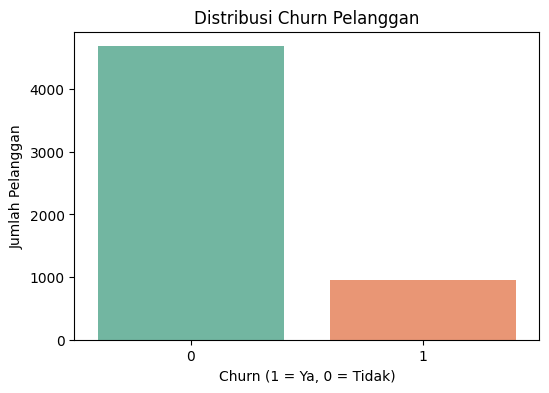

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribusi churn
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='Set2')
plt.title('Distribusi Churn Pelanggan')
plt.xlabel('Churn (1 = Ya, 0 = Tidak)')
plt.ylabel('Jumlah Pelanggan')
plt.show()

- Mayoritas pelanggan tidak churn, tetapi tetap ada proporsi signifikan yang churn.
- Insight: Meskipun sebagian besar pelanggan tetap bertahan, proporsi churn cukup penting untuk menjadi perhatian bisnis.

### Churn Berdasarkan Gender

In [15]:
# Hitung proporsi churn untuk setiap gender
gender_churn_rate = df.groupby('Gender')['Churn'].value_counts(normalize=True).unstack() * 100
gender_churn_rate = gender_churn_rate.rename(columns={0: 'Not Churned (%)', 1: 'Churned (%)'})

# Tampilkan hasil
gender_churn_rate.round(2)

Churn,Not Churned (%),Churned (%)
Gender,,
Female,84.51,15.49
Male,82.27,17.73


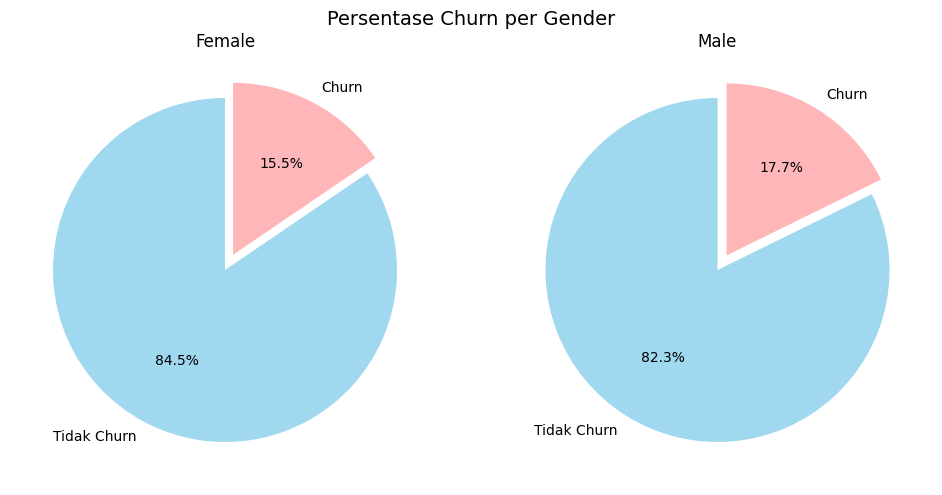

In [16]:
import matplotlib.pyplot as plt

# Hitung persentase churn dalam tiap gender
gender_grouped = df.groupby('Gender')['Churn'].value_counts(normalize=True).unstack() * 100

# Plot pie chart
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Female
axes[0].pie(gender_grouped.loc['Female'],
            labels=['Tidak Churn', 'Churn'],
            autopct='%.1f%%',
            colors=['#a0d8ef', '#ffb6b9'],
            startangle=90,
            explode=(0, 0.1))
axes[0].set_title('Female')

# Male
axes[1].pie(gender_grouped.loc['Male'],
            labels=['Tidak Churn', 'Churn'],
            autopct='%.1f%%',
            colors=['#a0d8ef', '#ffb6b9'],
            startangle=90,
            explode=(0, 0.1))
axes[1].set_title('Male')

plt.suptitle('Persentase Churn per Gender', fontsize=14)
plt.tight_layout()
plt.show()

Female: 15.5% churn
Male: 17.7% churn

Insight: Meskipun jumlah churn pria dan wanita mirip dalam hitungan absolut, pria memiliki persentase churn lebih tinggi → fokus strategi retensi bisa difokuskan ke segmen ini.

**Interpretasi**
- Perempuan memiliki tingkat churn sebesar 15.49% dari total pengguna perempuan.
- Laki-laki memiliki tingkat churn sebesar 17.73% dari total pengguna laki-laki.

**Hipotesis**
- Hipotesis Nol (H₀): Tidak terdapat perbedaan signifikan dalam tingkat churn antara pengguna laki-laki dan perempuan.
- Hipotesis Alternatif (H₁): Terdapat perbedaan signifikan dalam tingkat churn antara pengguna laki-laki dan perempuan.

In [17]:
from statsmodels.stats.proportion import proportions_ztest

# Jumlah churn dan total untuk masing-masing gender
churn_counts = df.groupby('Gender')['Churn'].sum()
total_counts = df['Gender'].value_counts()

# Urutkan agar sesuai
churn_counts = churn_counts.loc[['Male', 'Female']]
total_counts = total_counts.loc[['Male', 'Female']]

# Lakukan z-test
z_stat, p_value = proportions_ztest(count=churn_counts, nobs=total_counts)

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.3f}")

Z-statistic: 2.196
P-value: 0.028


Interpretasi:
Nilai p-value < 0.05, maka tolak hipotesis nol (ada perbedaan signifikan tingkat churn antara laki-laki dan perempuan).

### Churn Berdasarkan Kategori Order yang Disukai

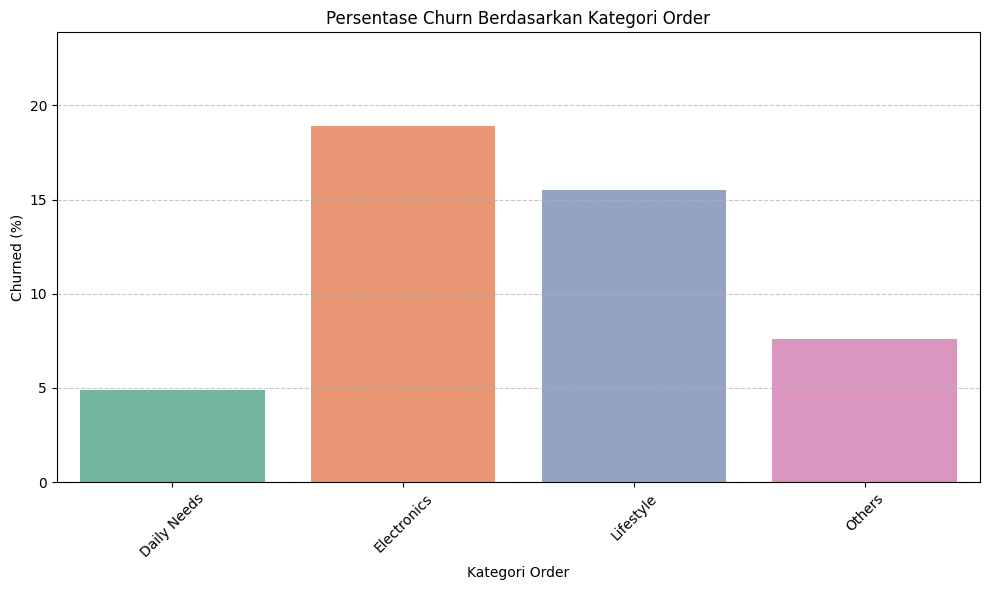

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Gabungkan kategori produk yang mirip
df['OrderCategoryGrouped'] = df['PreferedOrderCat'].replace({
    'Laptop & Accessory': 'Electronics',
    'Mobile': 'Electronics',
    'Mobile Phone': 'Electronics',
    'Mobile Phone and Accessory': 'Electronics',
    'Fashion': 'Lifestyle',
    'Grocery': 'Daily Needs',
    'Others': 'Others'
})

# Hitung proporsi churn per kategori
category_churn = df.groupby('OrderCategoryGrouped')['Churn'].value_counts(normalize=True).unstack() * 100
category_churn = category_churn.rename(columns={0: 'Not Churned (%)', 1: 'Churned (%)'})

# Visualisasi histogram proporsi churn
plt.figure(figsize=(10, 6))
sns.barplot(x=category_churn.index, y=category_churn['Churned (%)'], palette='Set2')
plt.title('Persentase Churn Berdasarkan Kategori Order')
plt.ylabel('Churned (%)')
plt.xlabel('Kategori Order')
plt.xticks(rotation=45)
plt.ylim(0, category_churn['Churned (%)'].max() + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Fokus retensi pelanggan di kategori Mobile Phone dan Fashion.
- Pertahankan strategi untuk kategori Laptop & Accessory dan Grocery karena pelanggan di sini relatif lebih setia.
- Lakukan personalisasi penawaran berdasarkan kategori preferensi.

### Heatmap Korelasi Fitur Numerik

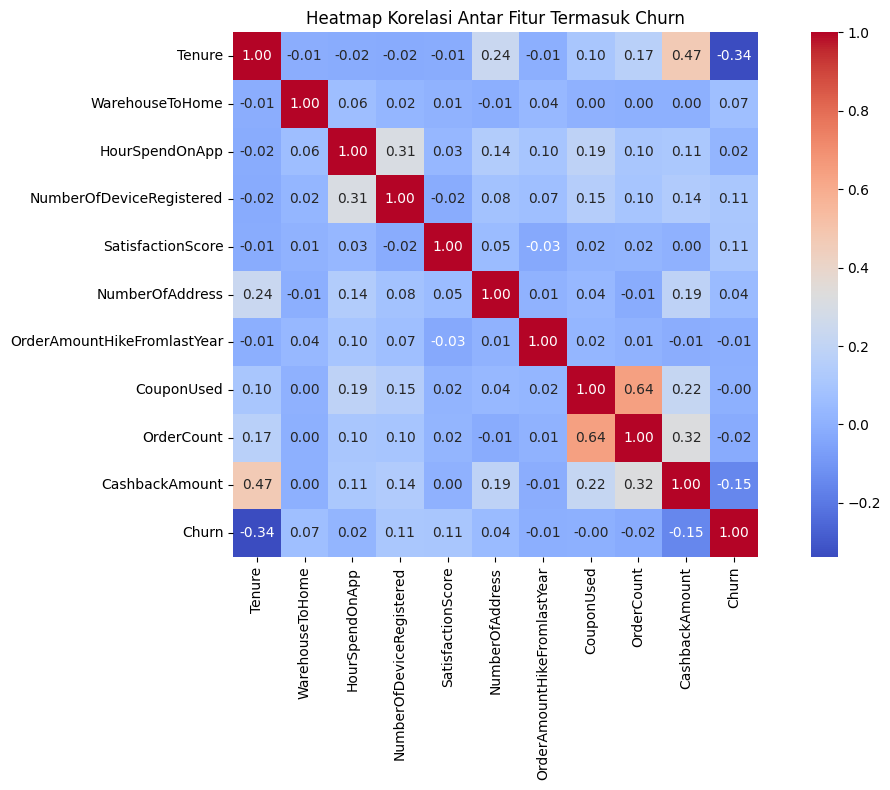

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pilih 10 fitur numerik + kolom target
selected_cols = [
    'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
    'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
    'CouponUsed', 'OrderCount', 'CashbackAmount', 'Churn'
]

# Ambil subset data
corr_data = df[selected_cols]

# Hitung matriks korelasi
correlation_matrix = corr_data.corr()

# Buat heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Heatmap Korelasi Antar Fitur Termasuk Churn")
plt.tight_layout()
plt.show()

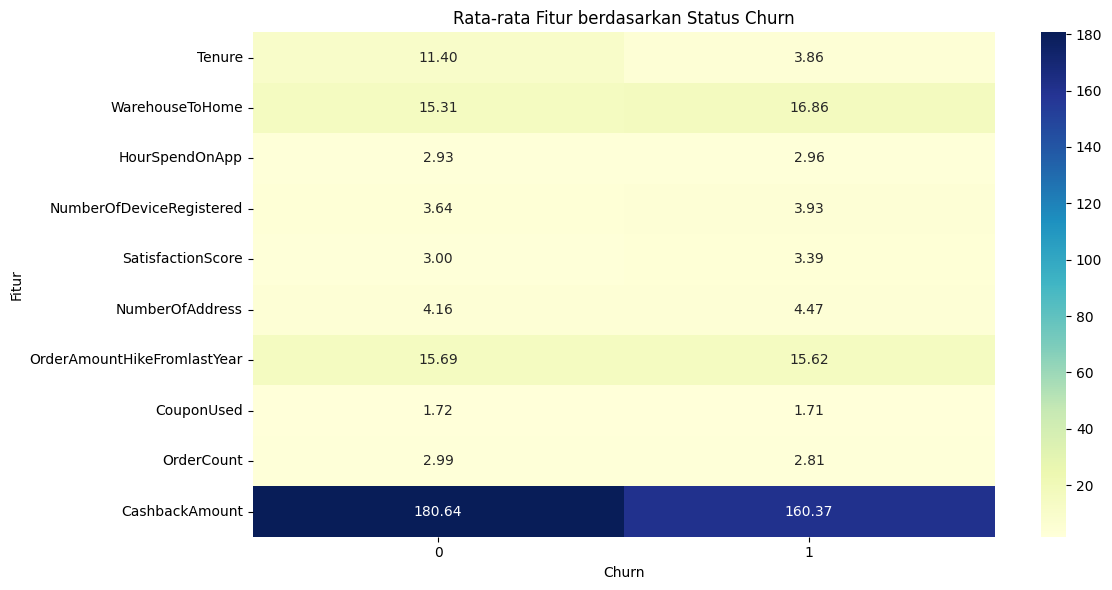

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pilih 10 fitur numerik yang relevan
selected_cols = [
    'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
    'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
    'CouponUsed', 'OrderCount', 'CashbackAmount'
]

# Hitung rata-rata tiap fitur berdasarkan Churn
churn_grouped = df.groupby('Churn')[selected_cols].mean()

# Buat heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(churn_grouped.T, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Rata-rata Fitur berdasarkan Status Churn")
plt.xlabel("Churn")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

Korelasi dengan variabel target Churn:
- Tenure memiliki korelasi negatif paling kuat dengan churn (-0.34).
Artinya, semakin lama pelanggan bertahan, semakin kecil kemungkinan mereka churn.
- CashbackAmount juga berkorelasi negatif (-0.15).
Pelanggan yang menerima lebih banyak cashback cenderung tetap setia.

- Fitur lain seperti SatisfactionScore, OrderCount, CouponUsed, dan NumberOfAddress hanya memiliki korelasi lemah (di bawah 0.1) terhadap churn.Artinya pengaruhnya kecil, tapi masih bisa jadi pendukung model.

Insight Strategis :
- Customer loyalty sangat dipengaruhi oleh lamanya waktu menjadi pelanggan (Tenure) dan nilai cashback yang diterima.
- Pelanggan yang tinggal lebih jauh dari warehouse cenderung churn → bisa diatasi dengan strategi logistik yang lebih baik (misal: ekspansi gudang).
- Fitur dengan pengaruh kecil (korelasi rendah) sebaiknya dipertimbangkan untuk dieliminasi dari model agar lebih efisien.
- Beberapa hasil seperti SatisfactionScore yang lebih tinggi di churner bisa jadi menunjukkan data bias atau label noise, perlu ditinjau kembali.

## Machine Learning Modelling

### Pisahkan Fitur & Split Data

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

# Pisahkan fitur dan target
X = df_model.drop(columns='Churn')
y = df_model['Churn']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

### Logistic Regression

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Inisialisasi model
model = LogisticRegression(max_iter=1000)

# Latih model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [23]:
# Prediksi probabilitas
y_train_probs = model.predict_proba(X_train)[:, 1]
y_test_probs = model.predict_proba(X_test)[:, 1]

In [24]:
# Hitung ROC AUC
train_auc = roc_auc_score(y_train, y_train_probs)
test_auc = roc_auc_score(y_test, y_test_probs)

In [25]:
# Print hasil
print(f"ROC AUC (Train): {train_auc:.4f}")
print(f"ROC AUC (Test): {test_auc:.4f}")

ROC AUC (Train): 0.8966
ROC AUC (Test): 0.8860


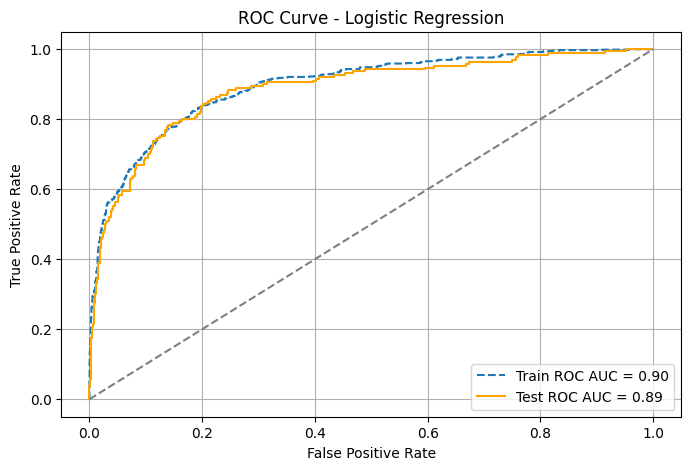

In [26]:
# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {train_auc:.2f}', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {test_auc:.2f}', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prediksi kelas (bukan probabilitas)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

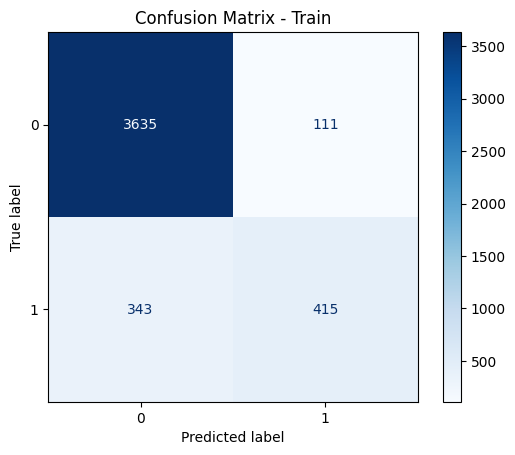

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix - TRAIN
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)
disp_train.plot(cmap="Blues")
plt.title("Confusion Matrix - Train")
plt.show()

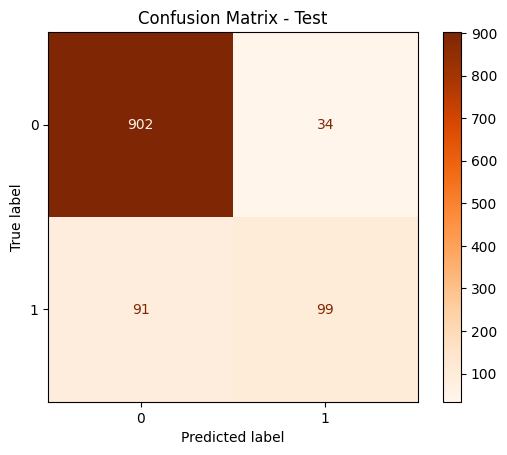

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix - TEST
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
disp_test.plot(cmap="Oranges")
plt.title("Confusion Matrix - Test")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === TRAIN METRICS ===
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print("🔵 TRAINING SET EVALUATION")
print(f"Accuracy  : {train_accuracy:.4f}")
print(f"Precision : {train_precision:.4f}")
print(f"Recall    : {train_recall:.4f}")
print(f"F1-Score  : {train_f1:.4f}")
print()

# === TEST METRICS ===
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("🟠 TEST SET EVALUATION")
print(f"Accuracy  : {test_accuracy:.4f}")
print(f"Precision : {test_precision:.4f}")
print(f"Recall    : {test_recall:.4f}")
print(f"F1-Score  : {test_f1:.4f}")

🔵 TRAINING SET EVALUATION
Accuracy  : 0.8992
Precision : 0.7890
Recall    : 0.5475
F1-Score  : 0.6464

🟠 TEST SET EVALUATION
Accuracy  : 0.8890
Precision : 0.7444
Recall    : 0.5211
F1-Score  : 0.6130


In [ ]:
import pandas as pd

# Simpan metrik ke dalam DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
})

# Tampilkan tabel metrik
print("📊 Evaluasi Metrik Logistic Regression")
display(metrics_df.round(4))


📊 Evaluasi Metrik Logistic Regression


,Metric,Train,Test
0,Accuracy,0.8992,0.8890
1,Precision,0.7890,0.7444
2,Recall,0.5475,0.5211
3,F1-Score,0.6464,0.6130


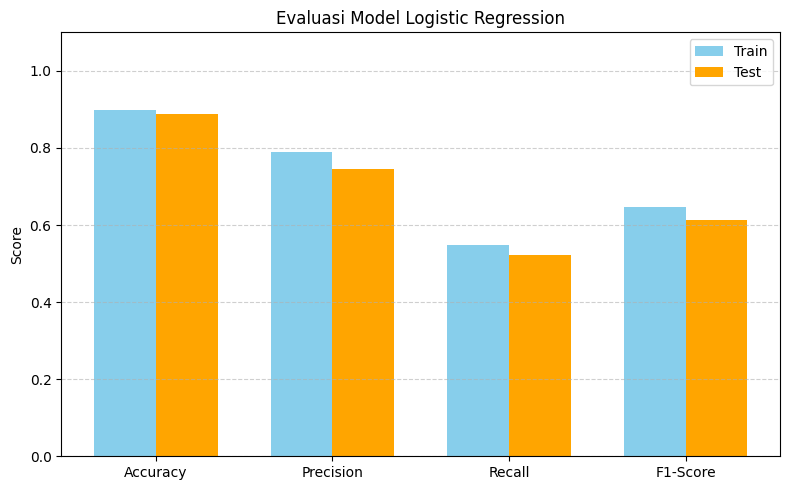

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data untuk bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, train_scores, width, label='Train', color='skyblue')
plt.bar(x + width/2, test_scores, width, label='Test', color='orange')

# Label dan layout
plt.ylabel('Score')
plt.title('Evaluasi Model Logistic Regression')
plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [ ]:
# Ambil nama fitur dari X_train
feature_names = X_train.columns

# Ambil koefisien dari model logistic regression
coefficients = model.coef_[0]

# Buat DataFrame koefisien
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Urutkan berdasarkan besarnya pengaruh (absolut nilai koefisien)
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

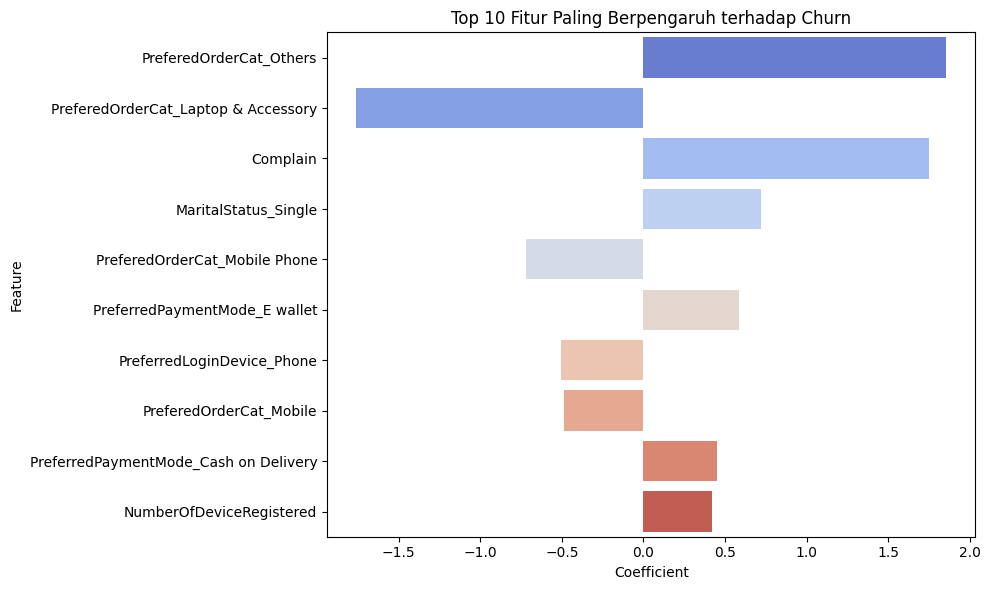

In [ ]:
# Ambil 10 fitur teratas
top_coef = coef_df.head(10)

# Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=top_coef, x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 10 Fitur Paling Berpengaruh terhadap Churn')
plt.tight_layout()
plt.show()

Insight
- Kategori produk sangat memengaruhi churn: pelanggan yang berbelanja "Others" dan "Grocery" lebih mudah churn, sementara yang beli gadget (HP, laptop) cenderung loyal.
- Komplain adalah indikator churn yang kuat – penting untuk ditangani cepat.
- Status lajang, metode pembayaran COD/e-wallet, dan login device juga berperan penting.
- Pelanggan yang menggunakan mobile phone sebagai login device dan berbelanja kategori elektronik jauh lebih loyal dibanding yang tidak.